# Visualize DiffusionDB Images with WizMap

In this notebook, we demonstrate how to use WizMap to visualize images and text
from the [DiffusionDB](https://huggingface.co/datasets/poloclub/diffusiondb)
dataset.


In [1]:
# Install wizmap
# !pip install --upgrade wizmap umap-learn

In [26]:
from glob import glob
from os.path import exists, join, basename
from tqdm import tqdm
from json import load, dump
from matplotlib import pyplot as plt
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from scipy.sparse import csr_matrix
from sklearn.neighbors import KernelDensity
from scipy.stats import norm
from typing import Tuple
from io import BytesIO
from umap import UMAP
from openai import AsyncOpenAI

import pandas as pd
import numpy as np
import json
import requests
import urllib
import wizmap

SEED = 20230501

plt.rcParams["figure.dpi"] = 300

## 1. Extract Embeddings

We use OpenAI's embedding model to get embeddings for 1k stable diffusion image
prompts.

You can get the `part-000001.json` by downloading the `part-000001.zip` file
from
[diffusiondb](https://huggingface.co/datasets/poloclub/diffusiondb/blob/main/diffusiondb-large-part-1/part-000001.zip).


In [18]:
image_data = json.load(open("part-000001.json", "r"))

In [ ]:
# image_prompts = [(k, v["p"]) for k, v in image_data.items()]
# prompts = [item[1] for item in image_prompts]
# image_names = [item[0] for item in image_prompts]

# openai_client = AsyncOpenAI(api_key=input("OpenAI API Key: "))

# embedding_model = "text-embedding-3-large"
# results = await openai_client.embeddings.create(input=prompts, model=embedding_model)

# embeddings = [e.embedding for e in results.data]

# np.savez(c
#     "embedding_data.npz",
#     embeddings=embeddings,
#     image_names=image_names,
#     prompts=prompts,
# )

In [51]:
# To save time, we will just load pre-extracted embeddings
EMBEDDING_URL = "https://huggingface.co/datasets/xiaohk/embeddings/resolve/main/diffusiondb/openai-text-embeddings.npz"
stream = requests.get(EMBEDDING_URL, stream=True)
embedding_data = np.load(BytesIO(stream.content), allow_pickle=True)

In [53]:
image_names = embedding_data["image_names"]
prompts = embedding_data["prompts"]
embeddings = embedding_data["embeddings"]

print(f"Loaded {len(embeddings)} embeddings")

Loaded 1000 embeddings


## 2. Dimensionality Reduction

Then, we apply dimensionality reduction techniques (e.g., UMAP, t-SNE, PCA) to
project the embeddings from a 384-dimension space into a 2D space. Here we use
UMAP, but you can use any dimensionality reduction technique you like.

To save the time to run this notebook, we will use the UMAP's default
parameters. However, it's a good practice to tune the parameters when you are
using WizMap on your own dataset.


In [54]:
reducer = UMAP(metric="cosine")
embeddings_2d = reducer.fit_transform(embeddings)

/Users/jayw/.virtualenvs/openai/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


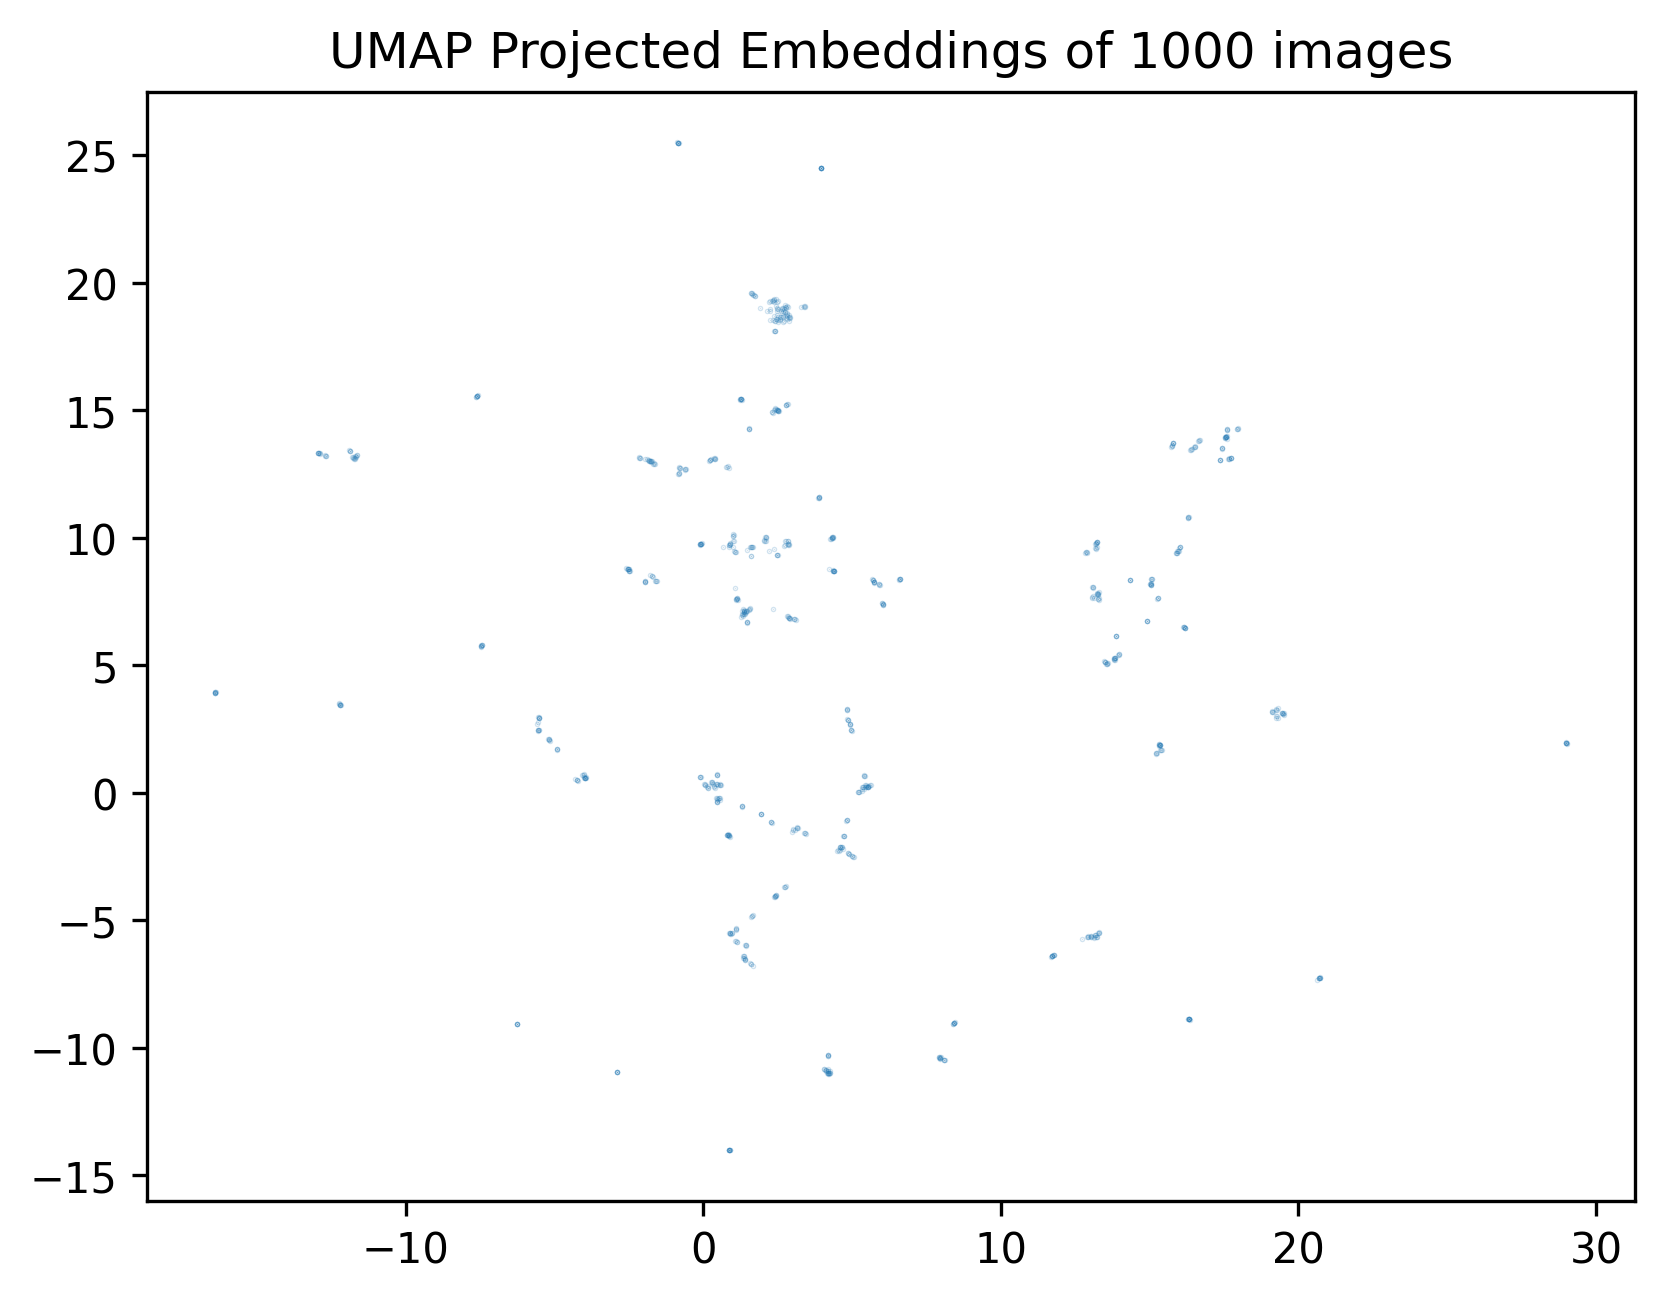

In [55]:
plt.title(f"UMAP Projected Embeddings of {len(embeddings)} images")
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=0.1, alpha=0.2)
plt.show()

## 3. Generate Two JSON Files for WizMap

To use WizMap on your embeddings, you need to generate two JSON files.

- One JSON file encodes the contour plot and multi-level summaries.
- The other JSON file encodes the raw data (e.g., IMDB reviews in this example).

Fortunately, the `WizMap` Python library makes it extremely easy to generate
these two files.


In [56]:
xs = embeddings_2d[:, 0].astype(float).tolist()
ys = embeddings_2d[:, 1].astype(float).tolist()

In [61]:
# Here we are writing a json string as the text content
# In the JSON object, we include the
json_strings = []
for i, name in enumerate(image_names):
    cur_url_part = f"{name[:2]}/{name}"
    json_strings.append(json.dumps({"i": cur_url_part, "t": prompts[i]}))

json_point_content_config = wizmap.JsonPointContentConfig(
    group_labels=[0],
    text_key="t",
    image_key="i",
    image_url_prefix="https://raw.githubusercontent.com/poloclub/diffusiondb-thumbnails/master/",
)

In [62]:
data_list = wizmap.generate_data_list(xs, ys, json_strings)
grid_dict = wizmap.generate_grid_dict(
    xs,
    ys,
    json_strings,
    "DiffusionDB Images",
    json_point_content_config=json_point_content_config,
)

Start generating data list...
Start generating contours...
Start generating multi-level summaries...


1000it [00:00, 286105.32it/s]
100%|██████████| 6/6 [00:00<00:00, 37.47it/s]


In [63]:
# Save the JSON files
wizmap.save_json_files(data_list, grid_dict, output_dir="./")

## 4. Host JSON Files and Display WizMap

After generating these two JSON files (one with `.json` and one with `.ndjson`),
you want to store them somewhere in the network so that you can provide two URLs
to WizMap.

Depending on your needs, there are many options to store the files.

1. **Local host**. If you are running WizMap on your local machine, you can
   simply start a local server and use ‘local host’ URLs to send your JSON files
   to WizMap.
2. **Static website hosting service** (e.g., GitHub page, Vercel, Hugging Face).
   You can use many free website hosting services to host your JSON files. A
   limitation is that these service usually have file size limits. For example,
   you can only include files that are less than 100MB in GitHub.
3. **Cloud storage** (e.g., AWS S3, Cloudflare R2). The most general option is
   to put the JSON files on a cloud storage site. There is no size limit, but
   you might need to pay for the service.

Here, we store `data.ndjson` and `grid.json` in
[Hugging Face](https://huggingface.co/datasets/xiaohk/embeddings/blob/main/imdb/).
